In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import bambi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import arviz as az

plt.rcParams['axes.labelsize'] = '14'

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing

In [2]:
data_path = "../data/experiment1-2d"

In [3]:
def merge_csv_files(data_path):
    dfs = []
    raw_data_path = os.path.join(data_path, 'raw')
    for file in os.listdir(raw_data_path):
        file_path = os.path.join(raw_data_path, file)
        if file_path.endswith('.csv'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join(data_path, 'raw_data_merged.csv'), index=False, sep='\t')

merge_csv_files(data_path = "../data/experiment1-2d")

../data/experiment1-2d\raw\participant_2381_20210809_1114.csv
../data/experiment1-2d\raw\participant_3782_20210805_1323.csv
../data/experiment1-2d\raw\participant_4573_20210809_1620.csv
../data/experiment1-2d\raw\participant_5909_20210805_1659.csv
../data/experiment1-2d\raw\participant_6240_20210809_1608.csv
../data/experiment1-2d\raw\participant_8212_20210812_1614.csv
../data/experiment1-2d\raw\participant_9413_20210809_2105.csv
../data/experiment1-2d\raw\participant_9452_20210804_1603.csv


In [4]:
def preprocess_data(data):
    excluded_participants = [3782, 6240, 8212, 9413]
    data = data[~data.participant_id.isin(excluded_participants)]
    
    # only looking at test (not training/filler) no-collision trials where a decision was made
    data = data[~((data.decision == "None") | data.collision) & data.is_test_trial]
       
    print("Valid trials:", len(data))
    print("Extreme RTs:", len(data[~((data.RT>0) & (data.RT<3))]))
    data = data[(data.RT>0) & (data.RT<3)].reset_index()

        
    condition_map = {"[0.0, 0.0, 0.0, 0.0]": "Constant speed", 
                 "[0.0, -3.0, 3.0, 0.0]": "Deceleration nudge", 
                 "[0.0, 3.0, -3.0, 0.0]": "Acceleration nudge"}
    data['nudge_condition'] = data['a_condition'].map(condition_map)
    
    data["p_go_decision"] = data.decision == "go"
    data = data.join(pd.DataFrame(data["a_condition"].str.strip("[]").str.split(",").to_list(),
                                  columns=["a_0", "a_1", "a_2", "a_3"]))
    data = data.astype({"a_0": float, "a_1": float, "a_2": float, "a_3": float})
    
    return data

data = pd.read_csv(os.path.join(data_path, "raw_data_merged.csv"), sep="\t")
data = preprocess_data(data)

Valid trials: 1619
Extreme RTs: 31


# Main analyses

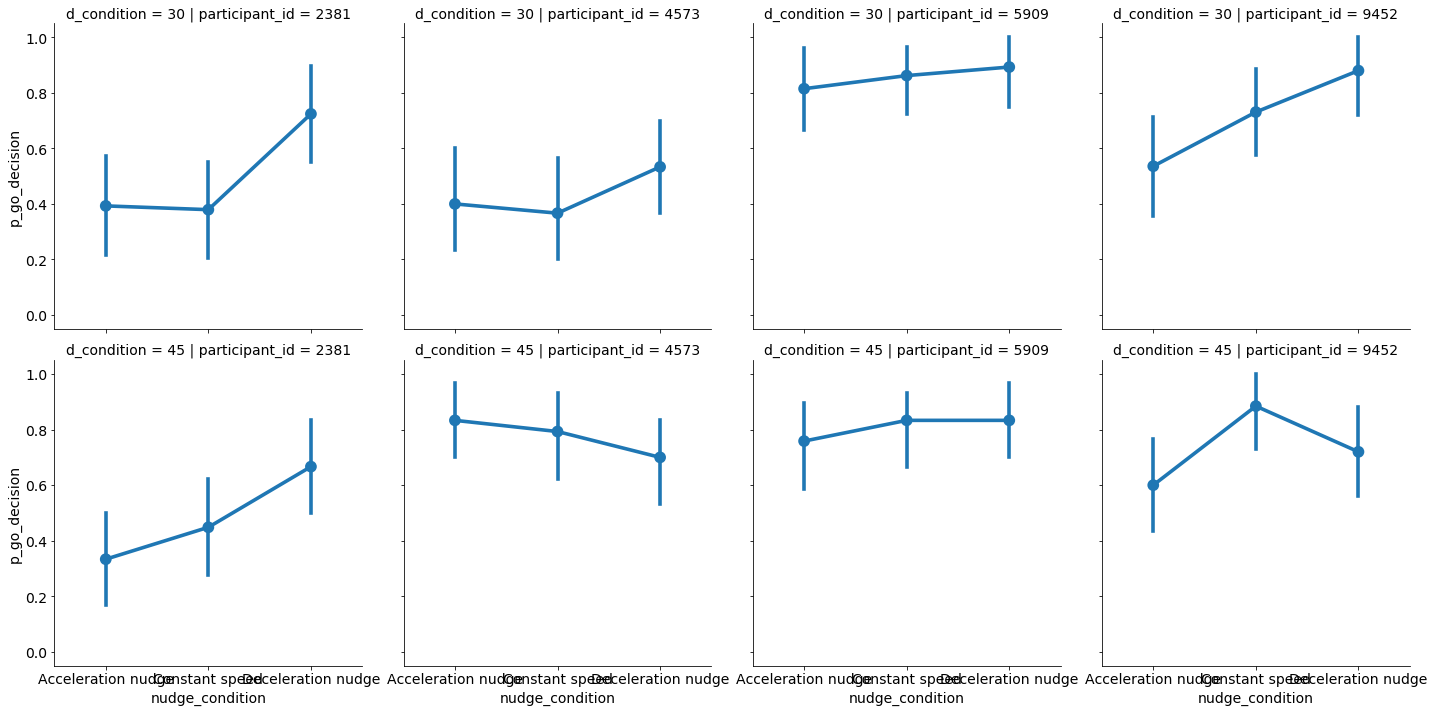

In [5]:
g = sns.catplot(data=data, x="nudge_condition", y="p_go_decision", row="d_condition", col="participant_id", kind="point", 
            order=["Acceleration nudge", "Constant speed", "Deceleration nudge"])
for ax in g.axes[0]:
    ax.set_ylim((-0.05, 1.05))

plt.savefig("../figures/p_turn_nudge.png", bbox_inches='tight')


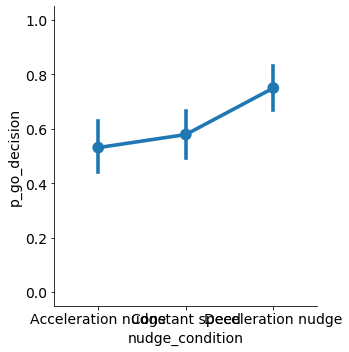

In [7]:
g = sns.catplot(data=data[data.d_condition==30], x="nudge_condition", y="p_go_decision", kind="point",
            order=["Acceleration nudge", "Constant speed", "Deceleration nudge"])
for ax in g.axes[0]:
    ax.set_ylim((-0.05, 1.05))

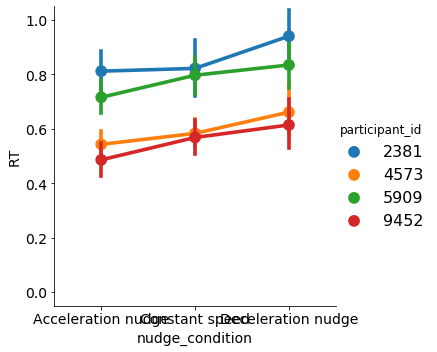

In [11]:
g = sns.catplot(data=data[data.p_go_decision==1], x="nudge_condition", y="RT", kind="point", hue="participant_id",
            order=["Acceleration nudge", "Constant speed", "Deceleration nudge"])
for ax in g.axes[0]:
    ax.set_ylim((-0.05, 1.05))

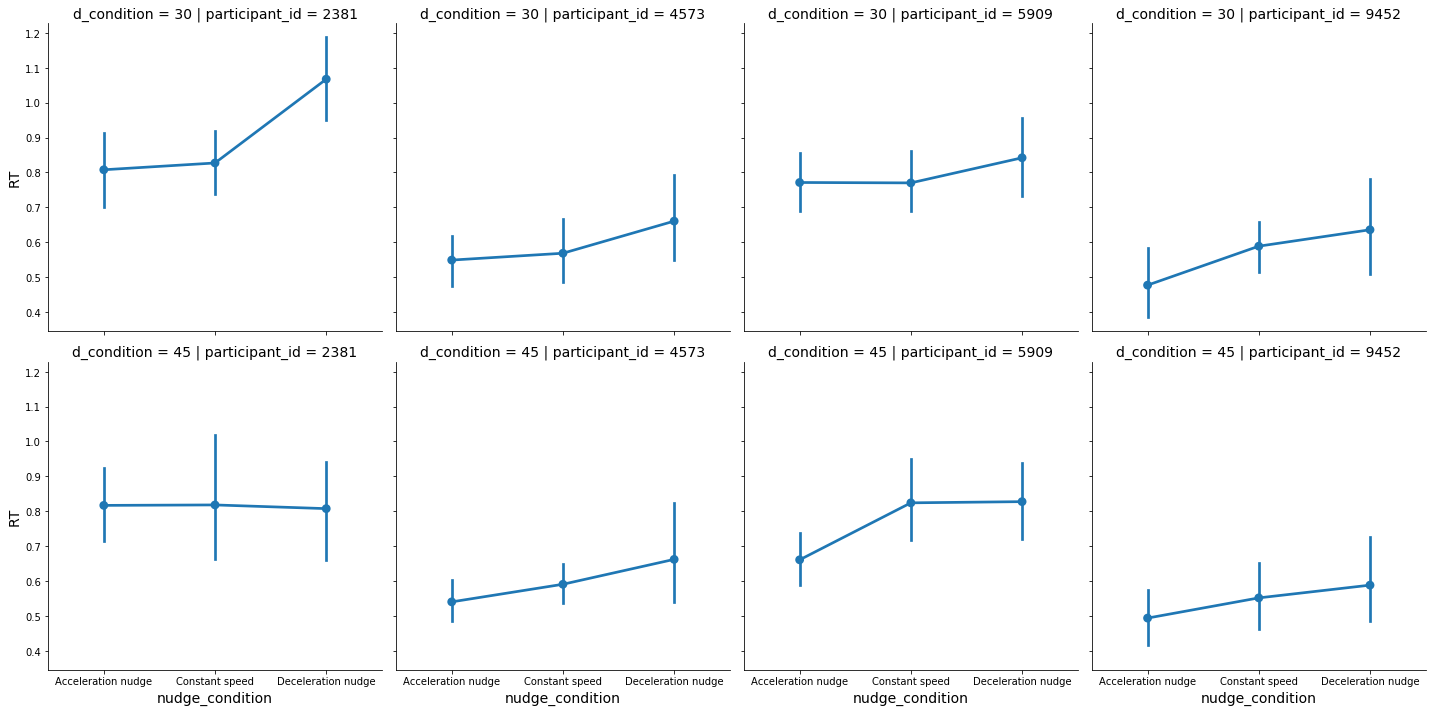

In [6]:
g = sns.catplot(data=data[data.decision=="go"], x="nudge_condition", y="RT", row="d_condition", col="participant_id", kind="point", 
            order=["Acceleration nudge", "Constant speed", "Deceleration nudge"])
# for ax in g.axes[0]:
#     ax.set_ylim((-0.05, 1.05))

plt.savefig("../figures/rt_go.png", bbox_inches='tight')

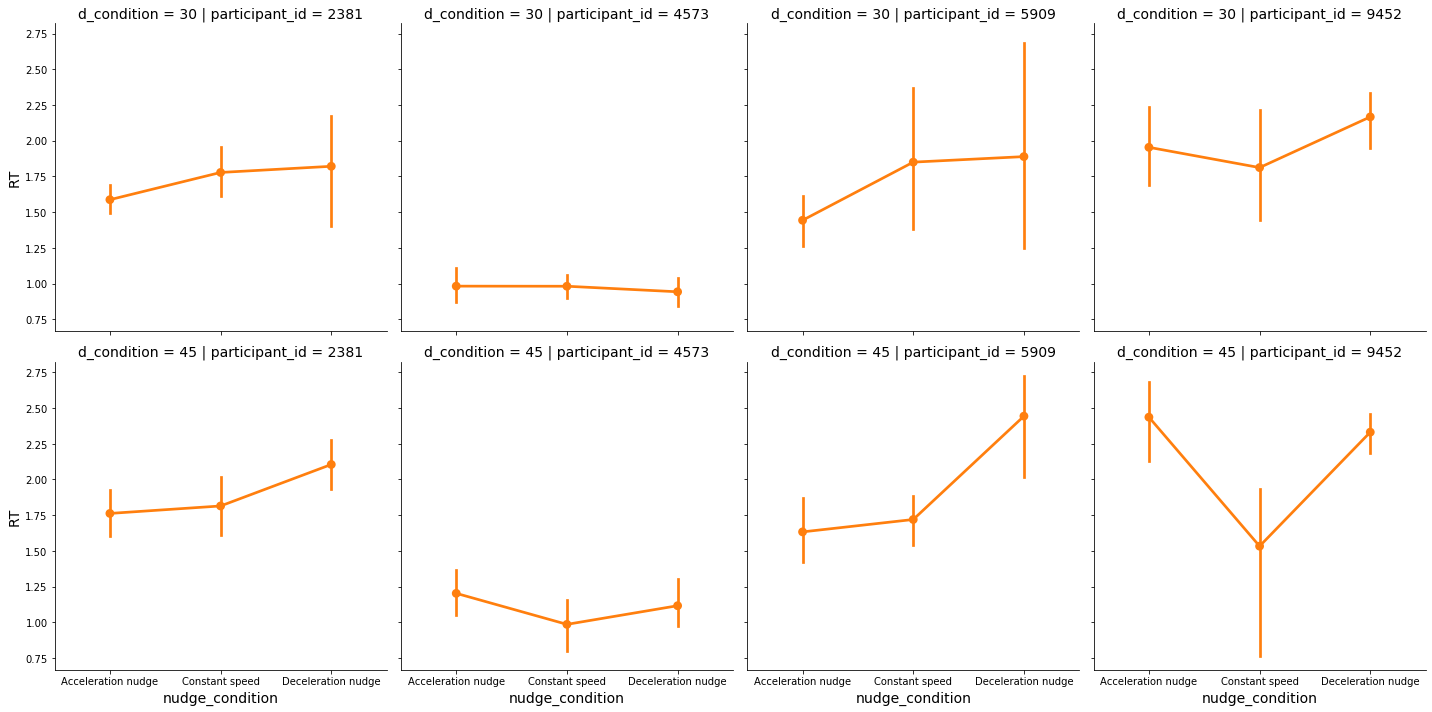

In [8]:
g = sns.catplot(data=data[data.decision=="stay"], x="nudge_condition", y="RT", row="d_condition", col="participant_id", kind="point", 
            order=["Acceleration nudge", "Constant speed", "Deceleration nudge"], color="C1")
# for ax in g.axes[0]:
#     ax.set_ylim((-0.05, 1.05))

plt.savefig("../figures/rt_stay.png", bbox_inches='tight')

# Descriptive plots per participant

In [3]:
def plot_RT_hist(data, save=False):
    plt.figure()
    plt.title("Participant %i" % (data.iloc[0].participant_id))
    sns.distplot(data[data.decision=="go"].RT, bins=20)
    sns.distplot(data[data.decision=="stay"].RT, bins=20)
    plt.gca().set_xlim((-0.05, 3.05))
    if save:
        plt.savefig("../figures/rt_hist_%i.png" % data.iloc[0].participant_id, bbox_inches='tight')

def plot_p_turn(data, save=False):
#     plt.figure()
    plt.title("Participant %i" % (data.iloc[0].participant_id))
    g = sns.catplot(data=data, x="a_1", y="p_go_decision", col="d_condition",
            hue="a_2", kind="point", dodge=True)
    for ax in g.axes[0]:
        ax.set_ylim((-0.05, 1.05))

    if save:
        plt.savefig("../figures/p_turn_%i.png" % data.iloc[0].participant_id, bbox_inches='tight')
        
def plot_rt(data, saave=False):
    sns.catplot(data=data, x="a_1", y="RT", row="decision", col="d_condition",
            hue="a_2", kind="point", estimator=np.nanmean)
    plt.savefig("../figures/rt_%i.png" % data.iloc[0].participant_id, bbox_inches='tight')

Valid trials: 405
Extreme RTs: 2
Valid trials: 419
Extreme RTs: 0
Valid trials: 415
Extreme RTs: 0
Valid trials: 405
Extreme RTs: 0
Valid trials: 406
Extreme RTs: 0
Valid trials: 412
Extreme RTs: 3
Valid trials: 416
Extreme RTs: 1
Valid trials: 394
Extreme RTs: 2


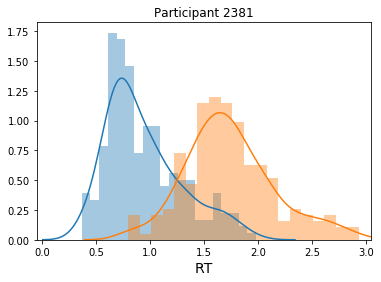

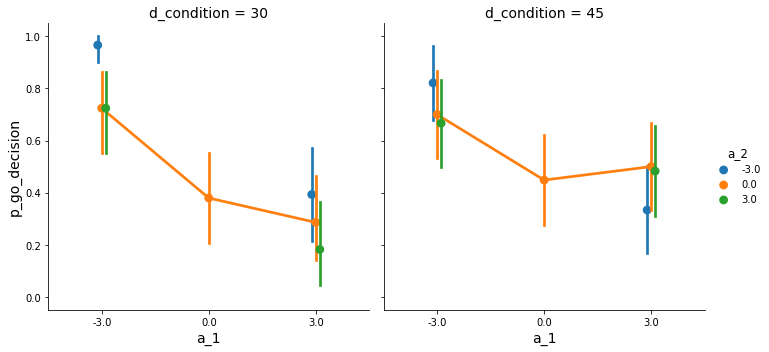

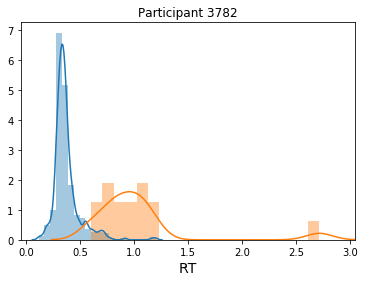

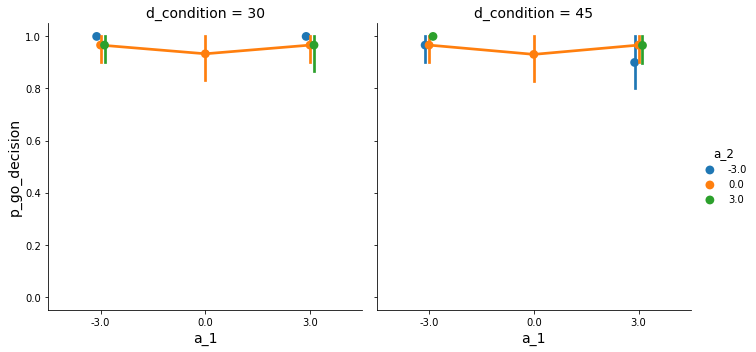

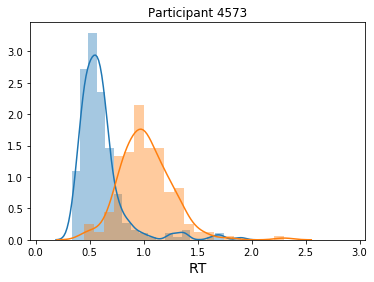

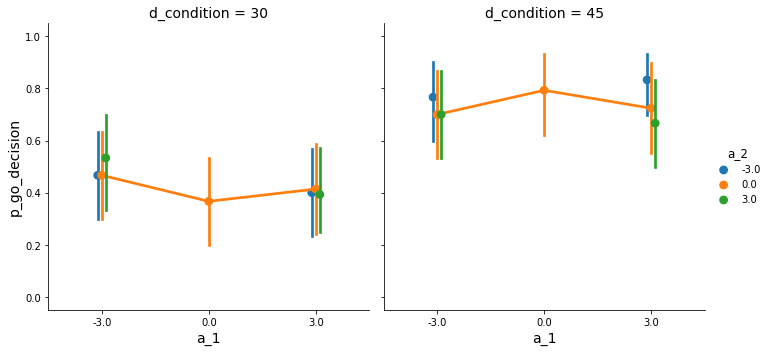

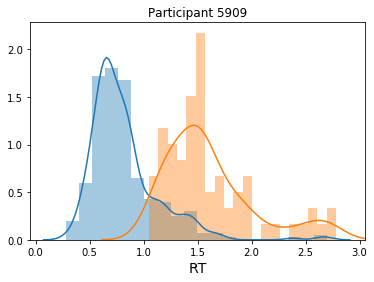

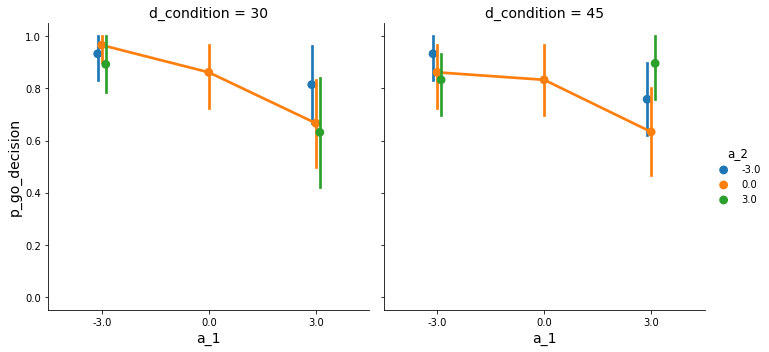

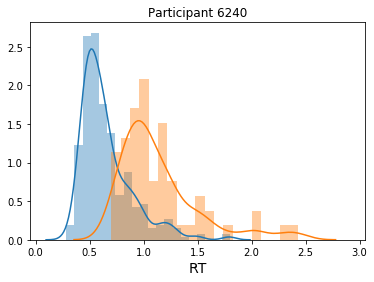

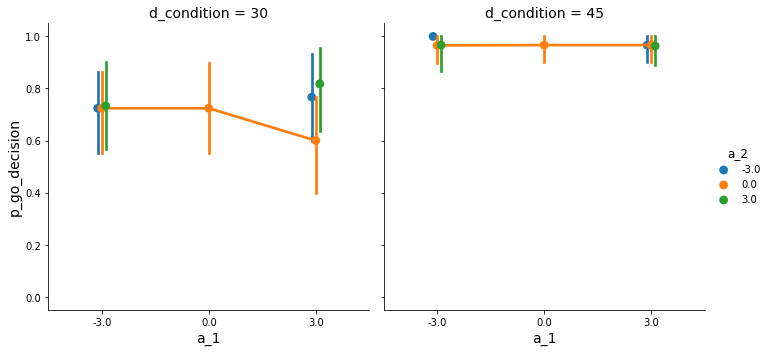

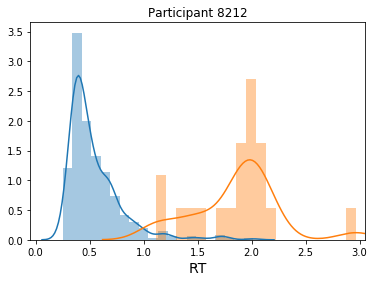

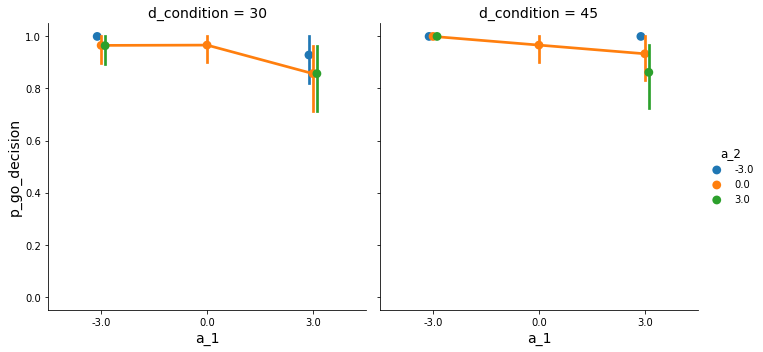

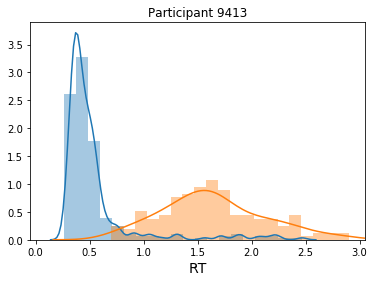

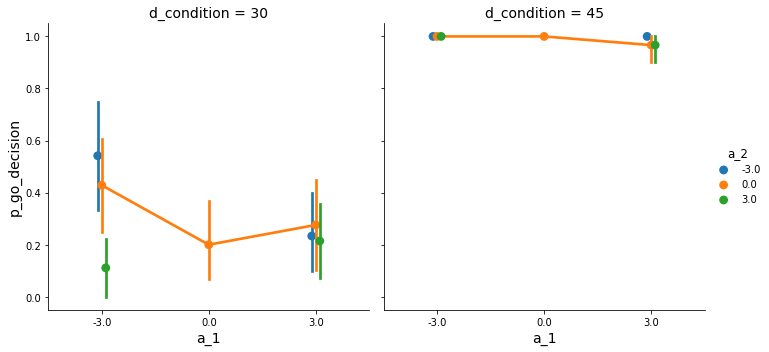

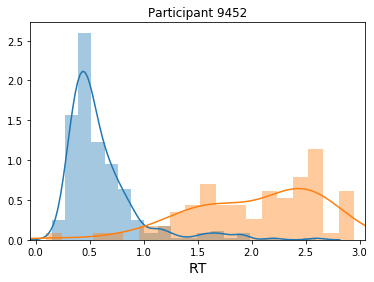

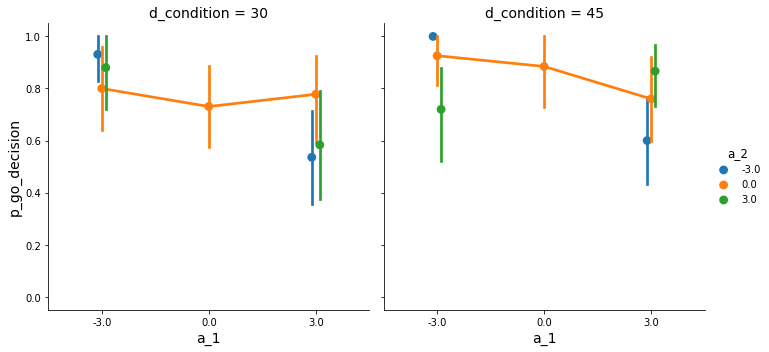

In [4]:
directory = "../data/experiment1-2d"
for filename in os.listdir(directory):
    data = pd.read_csv(os.path.join(directory, filename), sep="\t")
    data = preprocess_data(data)
    plot_RT_hist(data, save=True)
    plot_p_turn(data, save=True)

# Response times

Valid trials: 405
Extreme RTs: 2
Valid trials: 415
Extreme RTs: 0
Valid trials: 405
Extreme RTs: 0
Valid trials: 394
Extreme RTs: 2


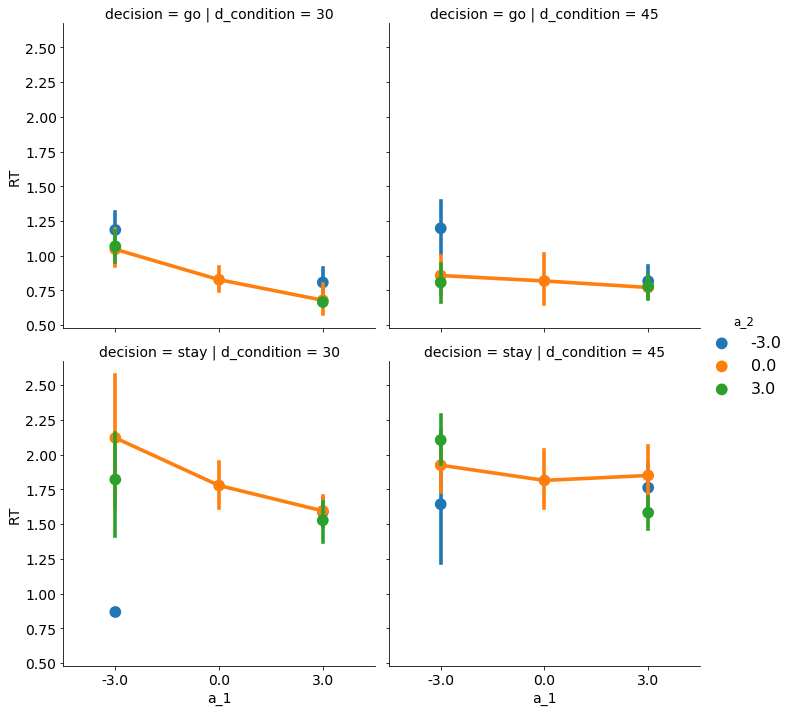

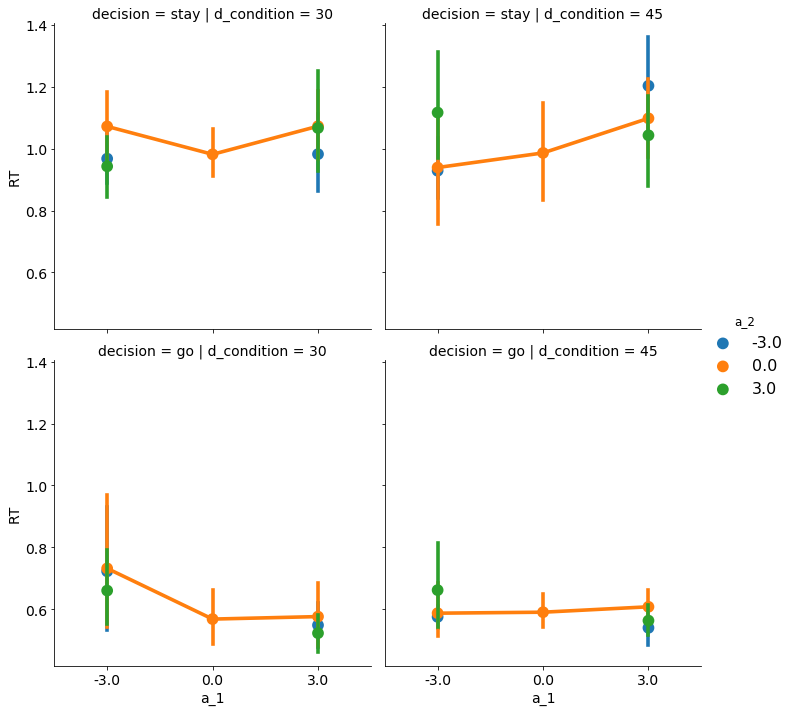

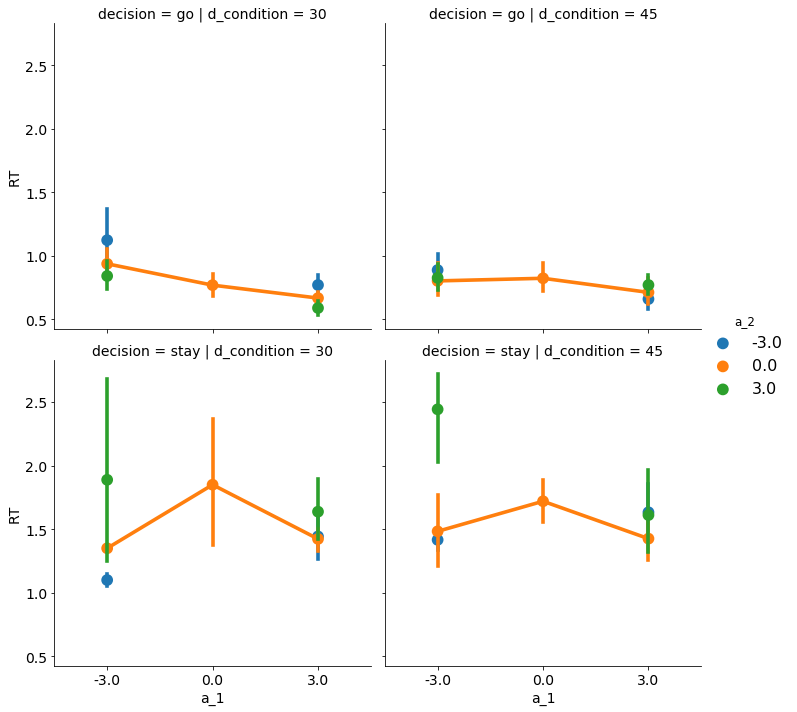

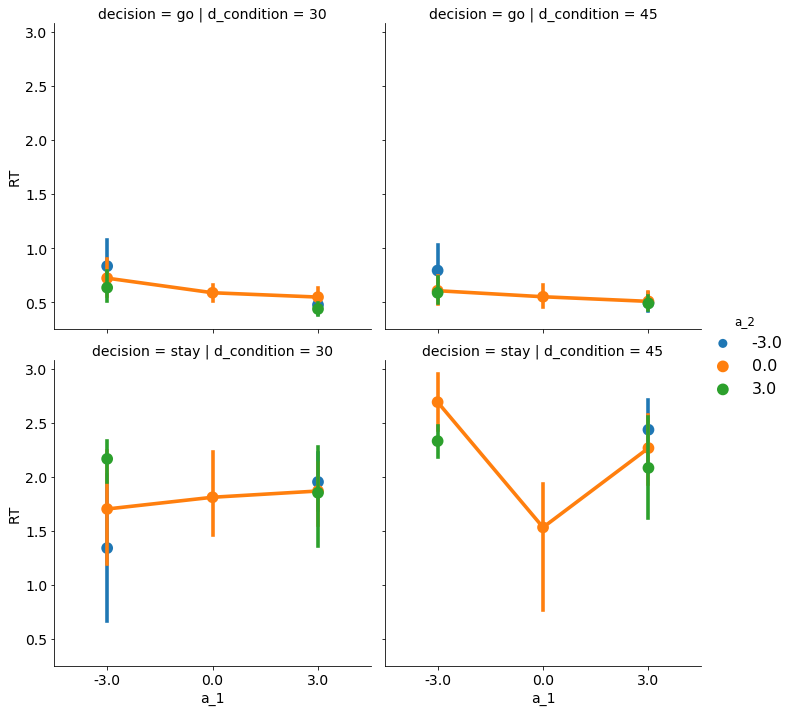

In [16]:
excluded_subjects = [3782, 6240, 8212, 9413]

for filename in os.listdir(directory):
    if not any(str(subj_id) in filename for subj_id in excluded_subjects):
        data = pd.read_csv(os.path.join(directory, filename), sep="\t")
        data = preprocess_data(data)
        plot_rt(data, save=True)

# Extra plots

No handles with labels found to put in legend.


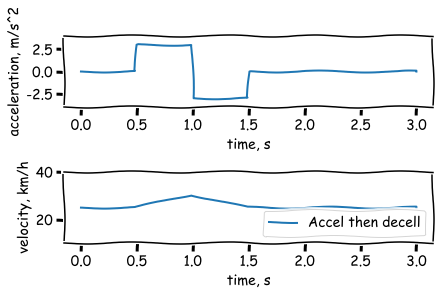

In [87]:
plt.xkcd()
fig, ax = plt.subplots(2,1,constrained_layout=True)
t = np.linspace(0,3,150)
n = 25
a = np.concatenate((np.zeros(n), 3*np.ones(n), -3*np.ones(n),
                    np.zeros(n), np.zeros(n), np.zeros(n)))
# ax.plot(t, a, label="Accel then decel")
# a = np.concatenate((np.zeros(n), -3*np.ones(n), 3*np.ones(n),
#                     np.zeros(n), np.zeros(n), np.zeros(n)))
ax[0].plot(t, a, color="C0", label="Accel then decell")
plt.legend(loc="upper right")
ax[0].set_ylim(-4, 4)
ax[0].set_xlabel("time, s")
ax[0].set_ylabel("acceleration, m/s^2")

# velocity
v = np.cumsum(a * np.nanmean(np.diff(t)))
v += 25. / 3.6


ax[1].plot(t, v * 3.6, color="C0", label="Accel then decell")
plt.legend(loc="lower right")
ax[1].set_ylim(10, 40)
ax[1].set_xlabel("time, s")
ax[1].set_ylabel("velocity, km/h")

plt.savefig("../figures/accel.png")
# plt.savefig("../figures/decel.png")

No handles with labels found to put in legend.


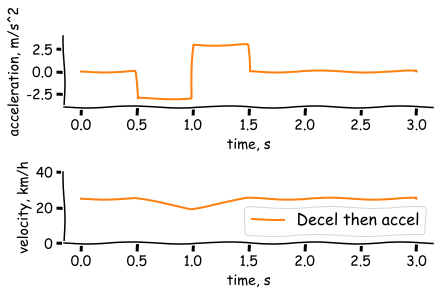

In [7]:
plt.xkcd()
fig, ax = plt.subplots(2,1,constrained_layout=True)
t = np.linspace(0,3,150)
n = 25
# a = np.concatenate((np.zeros(n), 3*np.ones(n), -3*np.ones(n),
#                     np.zeros(n), np.zeros(n), np.zeros(n)))
# ax.plot(t, a, label="Accel then decel")
a = np.concatenate((np.zeros(n), -3*np.ones(n), 3*np.ones(n),
                    np.zeros(n), np.zeros(n), np.zeros(n)))
ax[0].plot(t, a, color="C1", label="Decel then accel")
plt.legend(loc="upper right")
ax[0].set_ylim(-4, 4)
ax[0].set_xlabel("time, s")
ax[0].set_ylabel("acceleration, m/s^2")

# velocity
v = np.cumsum(a * np.nanmean(np.diff(t)))
v += 25. / 3.6


ax[1].plot(t, v * 3.6, color="C1", label="Decel then accel")
plt.legend(loc="lower right")
ax[1].set_ylim(10, 40)
ax[1].set_xlabel("time, s")
ax[1].set_ylabel("velocity, km/h")
ax[1].set_ylim(0, 40)
# plt.savefig("../figures/accel.png")
plt.savefig("../figures/decel.png")

# Stats

## Bayesian regression with bambi

## Frequentist regression with statsmodels

In [59]:
result = smf.ols(formula="p_go_decision ~ nudge_condition", data=data).fit()

In [61]:
result.summary()

ValueError: shapes (1374,2) and (1374,2) not aligned: 2 (dim 1) != 1374 (dim 0)

In [44]:
md = smf.mixedlm("p_go_decision ~ d_condition", data, groups=data["participant_id"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)